In [62]:
# import libraries
# DataFrame
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# sklearny
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB


#tensorflow
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

# Utility
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle

# Loading Dataset

In [63]:
# Construct a tf.data.Dataset
data = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding='latin', names = ['polarity','id','date','query','user','text'])
# Random shuffling of data, select the first 200,000
positives = data['polarity'][data.polarity == 4 ]
negatives = data['polarity'][data.polarity == 0 ]

print('Total length of the data is:         {}'.format(data.shape[0]))
print('No. of positve tagged sentences is:  {}'.format(len(positives)))
print('No. of negative tagged sentences is: {}'.format(len(negatives)))
data = data.sample(frac=1,random_state=740)
data = data[:20000]
data.head(10)

Total length of the data is:         1600000
No. of positve tagged sentences is:  800000
No. of negative tagged sentences is: 800000


,polarity,id,date,query,user,text
1586564,4,2190822209,Tue Jun 16 03:49:24 PDT 2009,NO_QUERY,Alex_Clough,...went to New Emperor as it was still open V...
1593258,4,2191903014,Tue Jun 16 06:10:21 PDT 2009,NO_QUERY,LeahChantelle,@lickmycupcakes Yay!!! It worked!! And thank y...
250171,0,1983150308,Sun May 31 12:36:04 PDT 2009,NO_QUERY,YesDiva32,@Mister_82 don't b hatin on my Mira Mira music
774617,0,2321582236,Wed Jun 24 21:15:45 PDT 2009,NO_QUERY,_WorldsApart_,"Where were u when #BPD broke 1,000 users onlin..."
219640,0,1976442803,Sat May 30 17:20:29 PDT 2009,NO_QUERY,greatbrytton,I really just want to be out of Dothan...more ...
364854,0,2048346997,Fri Jun 05 15:03:16 PDT 2009,NO_QUERY,MsCherrylicious,Fml got suckered into working til 930 and I'm ...
1081037,4,1968400415,Fri May 29 21:21:32 PDT 2009,NO_QUERY,pennamico,@aalmishal ???? ?? ????? ????? ????? ?????? ?...
352747,0,2031275962,Thu Jun 04 09:35:12 PDT 2009,NO_QUERY,darlingroland,"Today I could go get my new phone, probably wo..."
804759,4,1468569254,Tue Apr 07 02:28:17 PDT 2009,NO_QUERY,Scyranth,@SexySubKaylee heh heh dirty is always good gu...
903760,4,1694686706,Mon May 04 03:43:12 PDT 2009,NO_QUERY,LmaonadeStand,No school today - Not because of &quot;H1N1&qu...


# Data Visualization

In [64]:
print("Dataset shape:", data.shape)

Dataset shape: (20000, 6)


In [65]:
# Replacing the value 4 -->1 for ease of understanding.
data['polarity'] = data['polarity'].replace(4,1)
data.head()

,polarity,id,date,query,user,text
1586564,1,2190822209,Tue Jun 16 03:49:24 PDT 2009,NO_QUERY,Alex_Clough,...went to New Emperor as it was still open V...
1593258,1,2191903014,Tue Jun 16 06:10:21 PDT 2009,NO_QUERY,LeahChantelle,@lickmycupcakes Yay!!! It worked!! And thank y...
250171,0,1983150308,Sun May 31 12:36:04 PDT 2009,NO_QUERY,YesDiva32,@Mister_82 don't b hatin on my Mira Mira music
774617,0,2321582236,Wed Jun 24 21:15:45 PDT 2009,NO_QUERY,_WorldsApart_,"Where were u when #BPD broke 1,000 users onlin..."
219640,0,1976442803,Sat May 30 17:20:29 PDT 2009,NO_QUERY,greatbrytton,I really just want to be out of Dothan...more ...


In [66]:
# check the number of positive vs. negative tagged sentences
positives = data['polarity'][data.polarity == 1 ]
negatives = data['polarity'][data.polarity == 0 ]

print('Total length of the data is:         {}'.format(data.shape[0]))
print('No. of positve tagged sentences is:  {}'.format(len(positives)))
print('No. of negative tagged sentences is: {}'.format(len(negatives)))

Total length of the data is:         20000
No. of positve tagged sentences is:  9880
No. of negative tagged sentences is: 10120


<Axes: xlabel='polarity', ylabel='count'>

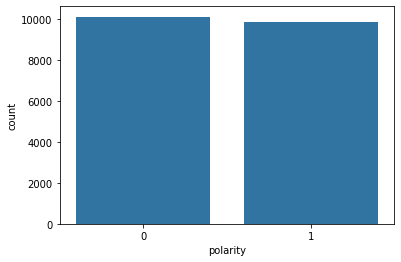

In [67]:
%matplotlib inline
sns.countplot(x=data['polarity'])

# Data Processing
## The Preprocessing steps taken are:
1. Lower Casing: Each text is converted to lowercase.
2. Removing URLs: Links starting with "http" or "https" or "www" are replaced by "".

3. Removing Usernames: Replace @Usernames with word "". (eg: "@XYZ" to "")

4. Removing Short Words: Words with length less than 2 are removed.
5. Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
6. Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “wolves” to “wolf”)

In [68]:
# Removing the unnecessary columns.
data.drop(['date','query','user'], axis=1, inplace=True)

In [69]:
data.drop('id', axis=1, inplace=True)
data.head(10)

,polarity,text
1586564,1,...went to New Emperor as it was still open V...
1593258,1,@lickmycupcakes Yay!!! It worked!! And thank y...
250171,0,@Mister_82 don't b hatin on my Mira Mira music
774617,0,"Where were u when #BPD broke 1,000 users onlin..."
219640,0,I really just want to be out of Dothan...more ...
364854,0,Fml got suckered into working til 930 and I'm ...
1081037,1,@aalmishal ???? ?? ????? ????? ????? ?????? ?...
352747,0,"Today I could go get my new phone, probably wo..."
804759,1,@SexySubKaylee heh heh dirty is always good gu...
903760,1,No school today - Not because of &quot;H1N1&qu...


In [48]:
data['text'] = data['text'].astype('str')

In [49]:
nltk.download('stopwords')
stopword = set(stopwords.words('english'))
print(stopword)

{"we've", 'being', 'there', 'doesn', "i'd", 'on', 'who', 't', 'until', 'again', "he'd", 'ours', 'very', 'did', 'up', "we'd", 'which', "you'll", "shouldn't", "we're", 'about', "i'm", "hadn't", 'so', 'here', "he's", "they've", 'doing', 'mustn', "i've", 'from', "mightn't", 'myself', 'if', 'ourselves', 'd', 'because', "doesn't", 'isn', "didn't", 'theirs', "should've", 'such', 'now', 'its', "isn't", 'my', "they're", 'is', 'wasn', 'too', "wasn't", 'off', "it'll", "weren't", 'mightn', 'her', 'with', 'most', "that'll", 'own', 'does', "aren't", 'of', 'yours', 'has', 'out', 'are', 're', 'through', 'y', 'i', 'hers', 'more', 'only', 'we', 'am', 'how', 'be', "he'll", 'him', "haven't", 'over', 'few', 'or', 'won', 'ma', 'your', 'you', "mustn't", 'she', 'above', 'will', 'me', 'their', 'can', "don't", 'other', 'down', "i'll", 'whom', "you're", 'they', 'don', "you've", "she'll", 'itself', 'as', 'had', 'o', "you'd", "shan't", 'didn', 'to', 'his', 'once', 'hadn', 'm', 'all', 'than', "it'd", 'each', 'he', 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/claudiachen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/claudiachen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/claudiachen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/claudiachen/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [70]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'

def process_tweets_negation_handling_fix(tweet):
    tweet = tweet.lower()

    tweet = re.sub(urlPattern,'',tweet)

    tweet = re.sub(userPattern,'', tweet)

    tweet = re.sub(r"[^\w\s']", '', tweet)

    tweet = re.sub(r"\bcan't\b", "cannot", tweet)

    tweet = re.sub(r"\bwon't\b", "will not", tweet)

    tweet = re.sub(r"\bshan't\b", "shall not", tweet)

    tweet = re.sub(r"\bain't\b", "is not", tweet)

    tweet = re.sub(r"n't\b", " not", tweet)

    tweet = re.sub(r"'", ' ', tweet)

    #tokenizing words
    tokens = word_tokenize(tweet)

    final_tokens = tokens

    wordLemm = WordNetLemmatizer()
    finalwords=[]

    for w in tokens:
        if len(w) > 1:
        
            word = wordLemm.lemmatize(w, pos='v')

            word = wordLemm.lemmatize(word, pos='n')
            finalwords.append(word)
    return ' '.join(finalwords)



In [71]:
data['processed_tweets'] = data['text'].apply(lambda x: process_tweets_negation_handling_fix(x))
print('Text Preprocessing complete.')

Text Preprocessing complete.


In [72]:
data.head(10)

,polarity,text,processed_tweets
1586564,1,...went to New Emperor as it was still open V...,go to new emperor a it be still open very nice...
1593258,1,@lickmycupcakes Yay!!! It worked!! And thank y...,yay it work and thank you blush
250171,0,@Mister_82 don't b hatin on my Mira Mira music,do not hatin on my mira mira music
774617,0,"Where were u when #BPD broke 1,000 users onlin...",where be when bpd break 1000 user online 628pm...
219640,0,I really just want to be out of Dothan...more ...,really just want to be out of dothanmore than ...
364854,0,Fml got suckered into working til 930 and I'm ...,fml get suckered into work til 930 and back in...
1081037,1,@aalmishal ???? ?? ????? ????? ????? ?????? ?...,
352747,0,"Today I could go get my new phone, probably wo...",today could go get my new phone probably will ...
804759,1,@SexySubKaylee heh heh dirty is always good gu...,heh heh dirty be always good gurl like how you...
903760,1,No school today - Not because of &quot;H1N1&qu...,no school today not because of quoth1n1quot bu...


# RNN - LSTM

In [54]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import re
import time
import keras
from keras import regularizers
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Embedding, LSTM, Dropout, BatchNormalization, LeakyReLU, PReLU

## Hyperparameters

In [55]:
num_epochs = 10
max_len = 200
hidden_units = 16
LSTM_layers = 1
LSTM_units = 8
max_words = 10000
embedding_dim = 128
learning_rate = 0.001
dropout = 0.0
mini_batch = 64
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

hidden_act= PReLU()
output_act= 'sigmoid'

## Converting text data into sequences

In [56]:

tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(data.processed_tweets)

sequences = tokenizer.texts_to_sequences(data.processed_tweets)


tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)
tweets.shape

[[   0    0    0 ...  105 7058 3774]
 [   0    0    0 ...   46    7 2727]
 [   0    0    0 ... 4802 4802  290]
 ...
 [   0    0    0 ...   46    7  105]
 [   0    0    0 ...    1  492  189]
 [   0    0    0 ...   78   17  269]]


(20000, 200)

## Split Traning and Test data

In [57]:
train_data, test_data, train_label, test_label = train_test_split(tweets, data.polarity.values, test_size=0.2, random_state=101)
print(np.unique(train_label))
print(np.unique(test_label))

[0 1]
[0 1]


## Creating and Traning LSTM Model

In [58]:
def create_lstm_model():
    model = Sequential()
    model.add(layers.Embedding(max_words, embedding_dim))
    for i in range(LSTM_layers):
        return_sequences = i < LSTM_layers - 1 
        model.add(layers.LSTM(LSTM_units, dropout=dropout, return_sequences=return_sequences))
    model.add(layers.Dense(hidden_units, activation=hidden_act))
    model.add(layers.Dense(hidden_units, activation=hidden_act))
    model.add(layers.Dense(1, activation=output_act))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [59]:
model = create_lstm_model()

history = model.fit(
    train_data, train_label,
    epochs=num_epochs,
    validation_data=(test_data, test_label),
    verbose=2
)


Epoch 1/10
500/500 - 19s - 39ms/step - accuracy: 0.7038 - loss: 0.5638 - val_accuracy: 0.7548 - val_loss: 0.5074
Epoch 2/10
500/500 - 16s - 31ms/step - accuracy: 0.8196 - loss: 0.4073 - val_accuracy: 0.7602 - val_loss: 0.5147
Epoch 3/10
500/500 - 16s - 32ms/step - accuracy: 0.8668 - loss: 0.3109 - val_accuracy: 0.7383 - val_loss: 0.6066
Epoch 4/10
500/500 - 17s - 35ms/step - accuracy: 0.9024 - loss: 0.2351 - val_accuracy: 0.7283 - val_loss: 0.6857
Epoch 5/10
500/500 - 16s - 32ms/step - accuracy: 0.9254 - loss: 0.1834 - val_accuracy: 0.7268 - val_loss: 0.8035
Epoch 6/10
500/500 - 17s - 34ms/step - accuracy: 0.9427 - loss: 0.1436 - val_accuracy: 0.7275 - val_loss: 0.9446
Epoch 7/10
500/500 - 16s - 32ms/step - accuracy: 0.9540 - loss: 0.1163 - val_accuracy: 0.7128 - val_loss: 1.0038
Epoch 8/10
500/500 - 16s - 32ms/step - accuracy: 0.9633 - loss: 0.0944 - val_accuracy: 0.7143 - val_loss: 1.2479
Epoch 9/10
500/500 - 16s - 32ms/step - accuracy: 0.9692 - loss: 0.0797 - val_accuracy: 0.7197 - 

In [60]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 200, 128)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (32, 8)                │         4,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 16)               │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 16)               │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 1)                │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,854,501 (14.70 MB)

 Trainable params: 1,284,833 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,569,668 (9.80 MB)

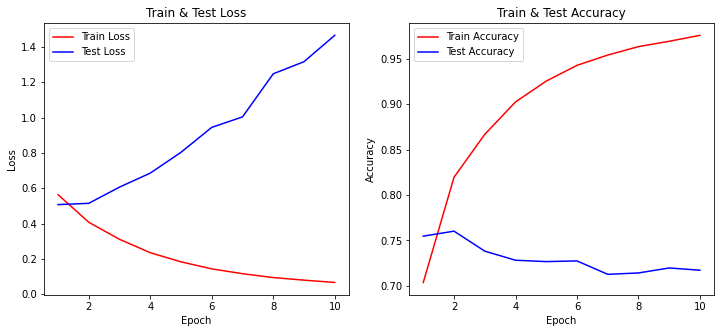

In [61]:
colors = ['red', 'orange', 'green', 'blue', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='Train Loss', color=colors[0])
axes[0].plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Test Loss', color=colors[3])
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Train & Test Loss")
axes[0].legend()

axes[1].plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], label='Train Accuracy', color=colors[0])
axes[1].plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], label='Test Accuracy', color=colors[3])
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Train & Test Accuracy")
axes[1].legend()

mini-batch = 8
Epoch 1/10
2000/2000 - 66s - 33ms/step - accuracy: 0.7243 - loss: 0.5417 - val_accuracy: 0.7555 - val_loss: 0.4993
Epoch 2/10
2000/2000 - 61s - 30ms/step - accuracy: 0.8256 - loss: 0.3874 - val_accuracy: 0.7500 - val_loss: 0.5300
Epoch 3/10
2000/2000 - 61s - 30ms/step - accuracy: 0.8808 - loss: 0.2808 - val_accuracy: 0.7393 - val_loss: 0.6380
Epoch 4/10
2000/2000 - 60s - 30ms/step - accuracy: 0.9169 - loss: 0.1974 - val_accuracy: 0.7295 - val_loss: 0.7901
Epoch 5/10
2000/2000 - 61s - 30ms/step - accuracy: 0.9429 - loss: 0.1404 - val_accuracy: 0.7295 - val_loss: 0.9977
Epoch 6/10
2000/2000 - 61s - 30ms/step - accuracy: 0.9597 - loss: 0.1014 - val_accuracy: 0.7140 - val_loss: 1.0633
Epoch 7/10
2000/2000 - 61s - 31ms/step - accuracy: 0.9712 - loss: 0.0759 - val_accuracy: 0.7128 - val_loss: 1.4353
Epoch 8/10
2000/2000 - 60s - 30ms/step - accuracy: 0.9779 - loss: 0.0572 - val_accuracy: 0.7130 - val_loss: 1.5293
Epoch 9/10
2000/2000 - 60s - 30ms/step - accuracy: 0.9812 - loss:

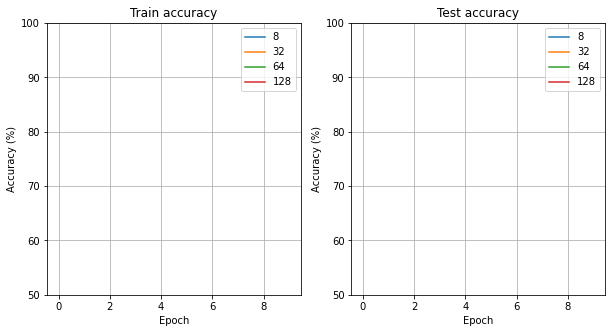

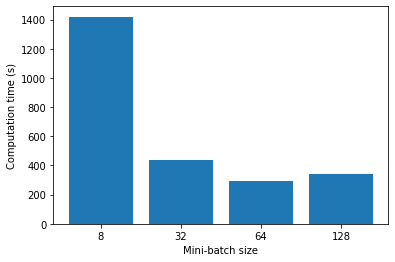

In [44]:
batchsizes = [8,32,64,128]
accuracyResultsTrain = np.zeros((num_epochs, len(batchsizes)))
accuracyResultsTest = np.zeros((num_epochs, len(batchsizes)))
comptime = np.zeros(len(batchsizes))

for bi in range(len(batchsizes)):
    print(f"mini-batch = {batchsizes[bi]}")
    # Start the timer to measure computation time
    starttime = time.process_time()

    model = create_lstm_model()

    history = model.fit(
        train_data, train_label,
        epochs=num_epochs,
        batch_size=batchsizes[bi],
        validation_data=(test_data, test_label),
        verbose=2
    )

    # Store training and testing accuracy results
    accuracyResultsTrain[:, bi] = history.history['accuracy']
    accuracyResultsTest[:, bi] = history.history['val_accuracy']

    # Record the computation time
    comptime[bi] = time.process_time() - starttime




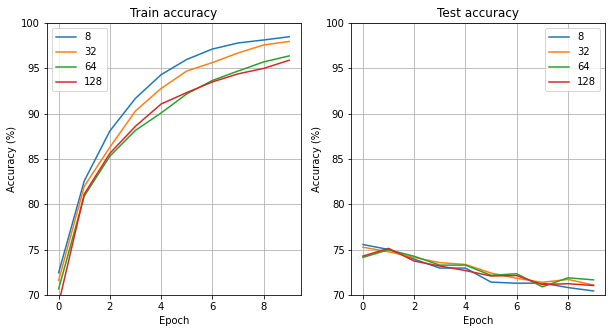

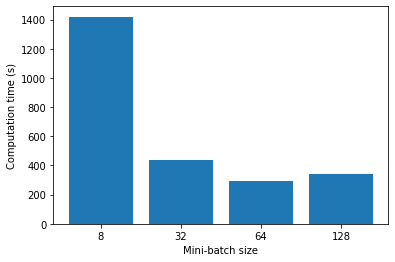

In [52]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(accuracyResultsTrain*100)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest*100)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(batchsizes)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([70,100])
  ax[i].grid()

plt.show()


# bar plot of computation time
plt.bar(range(len(comptime)),comptime,tick_label=batchsizes)
plt.xlabel('Mini-batch size')
plt.ylabel('Computation time (s)')
plt.show()

In [32]:
learningRates = [0.0001, 0.0004, 0.001, 0.006, 0.02]
optimTypes = ['SGD','RMSprop','Adam']
results = {}

def create_lstm_model_optimizer(optimizerAlgo,learningrate):
    optimizer_dict = {
        'Adam': tf.keras.optimizers.Adam(learning_rate=learningrate),
        'SGD': tf.keras.optimizers.SGD(learning_rate=learningrate),
        'RMSprop': tf.keras.optimizers.RMSprop(learning_rate=learningrate)
    }
    model = Sequential()
    model.add(layers.Embedding(max_words, embedding_dim))
    for i in range(LSTM_layers):
        return_sequences = i < LSTM_layers - 1 
        model.add(layers.LSTM(LSTM_units, dropout=dropout, return_sequences=return_sequences))
    model.add(layers.Dense(hidden_units, activation=hidden_act))
    model.add(layers.Dense(hidden_units, activation=hidden_act))
    model.add(layers.Dense(1, activation=output_act))

    optimizer = optimizer_dict.get(optimizerAlgo)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


for op in optimTypes:
    for lr in learningRates:
        print(f"Training model with {op} and {lr}")
        model = create_lstm_model_optimizer(op, lr)

        history = model.fit(
            train_data, train_label,
            epochs=num_epochs,
            batch_size=mini_batch,
            validation_data=(test_data, test_label),
            verbose=2
        )

        results[(op, lr)] = {
            'train_acc': history.history['accuracy'][-1],
            'test_acc': history.history['val_accuracy'][-1]
        }

Training model with SGD and 0.0001
Epoch 1/10
250/250 - 10s - 41ms/step - accuracy: 0.4867 - loss: 0.6939 - val_accuracy: 0.5020 - val_loss: 0.6935
Epoch 2/10
250/250 - 9s - 35ms/step - accuracy: 0.4884 - loss: 0.6938 - val_accuracy: 0.5017 - val_loss: 0.6935
Epoch 3/10
250/250 - 9s - 35ms/step - accuracy: 0.4909 - loss: 0.6937 - val_accuracy: 0.5015 - val_loss: 0.6935
Epoch 4/10
250/250 - 10s - 41ms/step - accuracy: 0.4926 - loss: 0.6936 - val_accuracy: 0.5033 - val_loss: 0.6934
Epoch 5/10
250/250 - 9s - 37ms/step - accuracy: 0.4939 - loss: 0.6935 - val_accuracy: 0.5027 - val_loss: 0.6934
Epoch 6/10
250/250 - 9s - 35ms/step - accuracy: 0.4955 - loss: 0.6935 - val_accuracy: 0.5040 - val_loss: 0.6934
Epoch 7/10
250/250 - 9s - 35ms/step - accuracy: 0.4962 - loss: 0.6934 - val_accuracy: 0.5055 - val_loss: 0.6934
Epoch 8/10
250/250 - 9s - 36ms/step - accuracy: 0.4981 - loss: 0.6934 - val_accuracy: 0.5060 - val_loss: 0.6934
Epoch 9/10
250/250 - 9s - 36ms/step - accuracy: 0.4984 - loss: 0.69

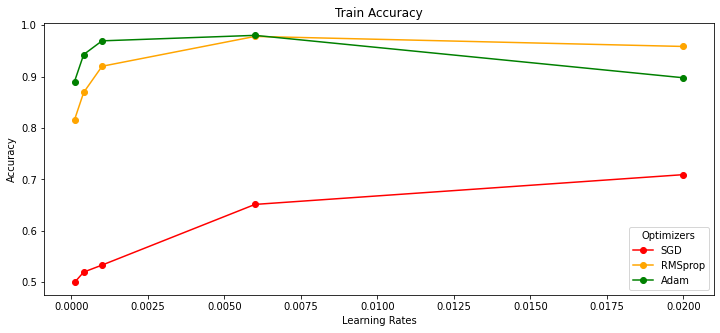

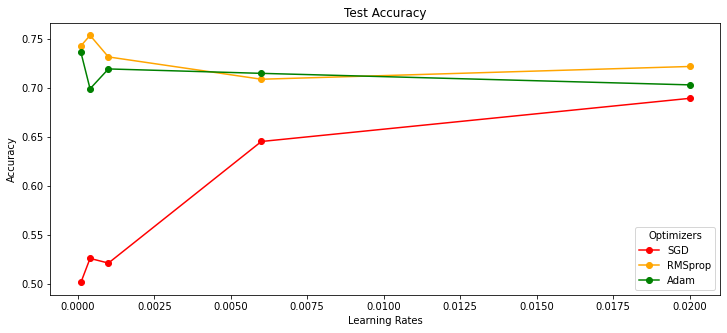

In [35]:
plt.figure(figsize=(12, 5))

for i, op in enumerate(optimTypes):
    train_acc = [results[(op, lr)]['train_acc'] for lr in learningRates]
    plt.plot(learningRates, train_acc, marker='o', linestyle='-', color=colors[i], label=f"{op}")
plt.xlabel("Learning Rates")
plt.ylabel("Accuracy")
plt.title("Train Accuracy")
plt.legend(title="Optimizers")
plt.show()


plt.figure(figsize=(12, 5))
for i, op in enumerate(optimTypes):
    test_acc = [results[(op, lr)]['test_acc'] for lr in learningRates]
    plt.plot(learningRates, test_acc, marker='o', linestyle='-', color=colors[i], label=f"{op}")
plt.xlabel("Learning Rates")
plt.ylabel("Accuracy")
plt.title("Test Accuracy")
plt.legend(title="Optimizers")
plt.show()

Training model with dropout 0.0 and recurrent dropout0.0
Epoch 1/10
250/250 - 15s - 61ms/step - accuracy: 0.7026 - loss: 0.5672 - val_accuracy: 0.7352 - val_loss: 0.5298
Epoch 2/10
250/250 - 13s - 50ms/step - accuracy: 0.7874 - loss: 0.4621 - val_accuracy: 0.7515 - val_loss: 0.5141
Epoch 3/10
250/250 - 12s - 47ms/step - accuracy: 0.8204 - loss: 0.4052 - val_accuracy: 0.7490 - val_loss: 0.5212
Epoch 4/10
250/250 - 11s - 43ms/step - accuracy: 0.8445 - loss: 0.3627 - val_accuracy: 0.7487 - val_loss: 0.5591
Epoch 5/10
250/250 - 11s - 45ms/step - accuracy: 0.8658 - loss: 0.3243 - val_accuracy: 0.7460 - val_loss: 0.5600
Epoch 6/10
250/250 - 11s - 44ms/step - accuracy: 0.8867 - loss: 0.2866 - val_accuracy: 0.7385 - val_loss: 0.5882
Epoch 7/10
250/250 - 11s - 44ms/step - accuracy: 0.9032 - loss: 0.2521 - val_accuracy: 0.7375 - val_loss: 0.6406
Epoch 8/10
250/250 - 11s - 44ms/step - accuracy: 0.9161 - loss: 0.2204 - val_accuracy: 0.7383 - val_loss: 0.6808
Epoch 9/10
250/250 - 11s - 43ms/step - 

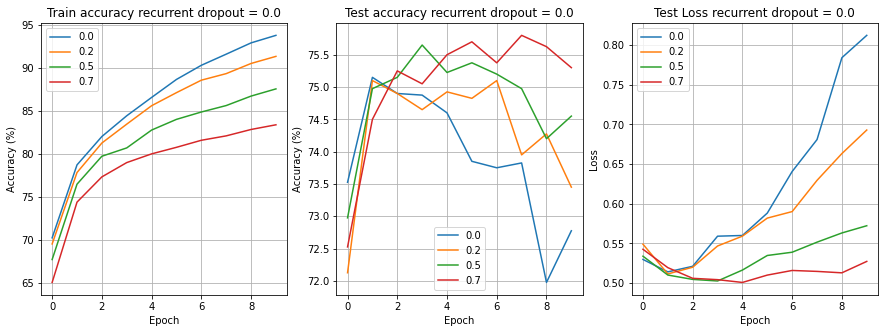

Training model with dropout 0.0 and recurrent dropout0.1
Epoch 1/10
250/250 - 20s - 81ms/step - accuracy: 0.6999 - loss: 0.5712 - val_accuracy: 0.7445 - val_loss: 0.5195
Epoch 2/10
250/250 - 18s - 71ms/step - accuracy: 0.7878 - loss: 0.4599 - val_accuracy: 0.7525 - val_loss: 0.5195
Epoch 3/10
250/250 - 18s - 72ms/step - accuracy: 0.8177 - loss: 0.4085 - val_accuracy: 0.7535 - val_loss: 0.5259
Epoch 4/10
250/250 - 18s - 72ms/step - accuracy: 0.8396 - loss: 0.3676 - val_accuracy: 0.7475 - val_loss: 0.5442
Epoch 5/10
250/250 - 18s - 71ms/step - accuracy: 0.8621 - loss: 0.3308 - val_accuracy: 0.7442 - val_loss: 0.5768
Epoch 6/10
250/250 - 18s - 72ms/step - accuracy: 0.8792 - loss: 0.2956 - val_accuracy: 0.7408 - val_loss: 0.6039
Epoch 7/10
250/250 - 18s - 71ms/step - accuracy: 0.8960 - loss: 0.2642 - val_accuracy: 0.7333 - val_loss: 0.6258
Epoch 8/10
250/250 - 18s - 71ms/step - accuracy: 0.9101 - loss: 0.2376 - val_accuracy: 0.7358 - val_loss: 0.6608
Epoch 9/10
250/250 - 18s - 71ms/step - 

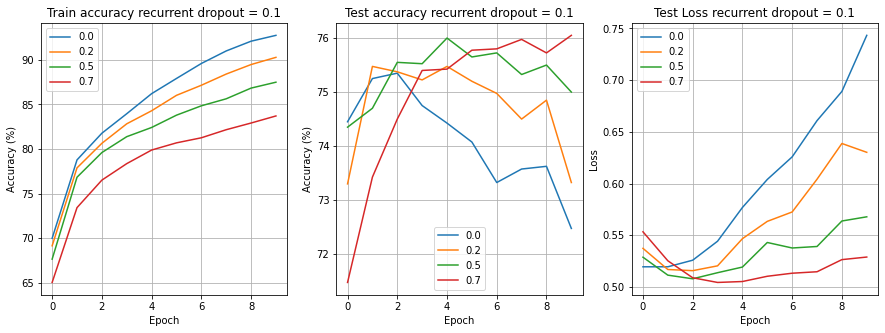

Training model with dropout 0.0 and recurrent dropout0.3
Epoch 1/10
250/250 - 19s - 77ms/step - accuracy: 0.6942 - loss: 0.5748 - val_accuracy: 0.7322 - val_loss: 0.5376
Epoch 2/10
250/250 - 17s - 68ms/step - accuracy: 0.7815 - loss: 0.4709 - val_accuracy: 0.7467 - val_loss: 0.5139
Epoch 3/10
250/250 - 18s - 72ms/step - accuracy: 0.8094 - loss: 0.4228 - val_accuracy: 0.7505 - val_loss: 0.5117
Epoch 4/10
250/250 - 19s - 76ms/step - accuracy: 0.8331 - loss: 0.3866 - val_accuracy: 0.7567 - val_loss: 0.5362
Epoch 5/10
250/250 - 17s - 70ms/step - accuracy: 0.8487 - loss: 0.3498 - val_accuracy: 0.7492 - val_loss: 0.5526
Epoch 6/10
250/250 - 18s - 70ms/step - accuracy: 0.8661 - loss: 0.3218 - val_accuracy: 0.7430 - val_loss: 0.5817
Epoch 7/10
250/250 - 17s - 69ms/step - accuracy: 0.8823 - loss: 0.2913 - val_accuracy: 0.7418 - val_loss: 0.6008
Epoch 8/10
250/250 - 18s - 71ms/step - accuracy: 0.8956 - loss: 0.2626 - val_accuracy: 0.7450 - val_loss: 0.6321
Epoch 9/10
250/250 - 17s - 69ms/step - 

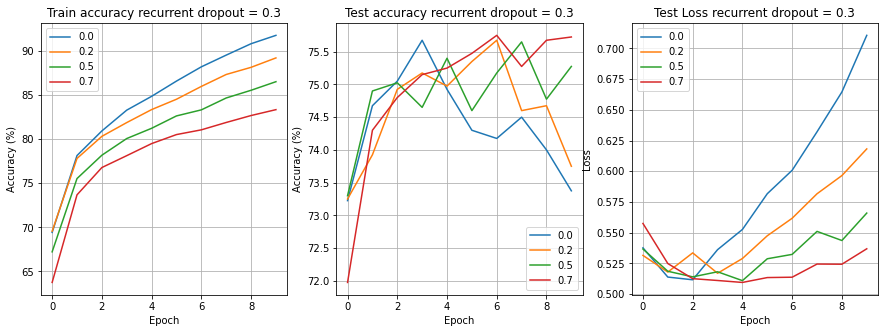

In [40]:
dropout_array = [0.0,0.2,0.5,0.7]
recurrent = [0.0,0.1,0.3]

def create_lstm_model_dropout(dp,rdp):
    model = Sequential()
    model.add(layers.Embedding(max_words, embedding_dim))
    for i in range(LSTM_layers):
        return_sequences = i < LSTM_layers - 1  
        model.add(layers.LSTM(LSTM_units, dropout=dp, recurrent_dropout=rdp, return_sequences=return_sequences))
    model.add(layers.Dense(hidden_units, activation=hidden_act))
    model.add(layers.Dense(hidden_units, activation=hidden_act))
    model.add(layers.Dense(1, activation=output_act))

    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

for rdp in recurrent:
    accuracyResultsTrain = np.zeros((num_epochs, len(dropout_array)))
    accuracyResultsTest = np.zeros((num_epochs, len(dropout_array)))
    loss = np.zeros((num_epochs, len(dropout_array)))
    for dp in range(len(dropout_array)):
        print(f"Training model with dropout {dropout_array[dp]} and recurrent dropout{rdp}")
        model = create_lstm_model_dropout(dropout_array[dp], rdp)

        history = model.fit(
            train_data, train_label,
            epochs=num_epochs,
            batch_size=mini_batch,
            validation_data=(test_data, test_label),
            verbose=2
        )
        accuracyResultsTrain[:, dp] = history.history['accuracy']
        accuracyResultsTest[:, dp] = history.history['val_accuracy']
        loss[:, dp] = history.history['val_loss']

    fig,ax = plt.subplots(1,3,figsize=(15,5))

    ax[0].plot(accuracyResultsTrain*100)
    ax[0].set_title(f'Train accuracy recurrent dropout = {rdp}')
    ax[1].plot(accuracyResultsTest*100)
    ax[1].set_title(f'Test accuracy recurrent dropout = {rdp}')
    ax[2].plot(loss)
    ax[2].set_title(f'Test Loss recurrent dropout = {rdp}')

    # common features
    for i in range(3):
        ax[i].legend(dropout_array)
        ax[i].set_xlabel('Epoch')
        ax[i].set_ylabel('Accuracy (%)')
        #ax[i].set_ylim([60,100])
        ax[i].grid()

    ax[2].set_ylabel('Loss')
    plt.show()

Epoch 1/10
250/250 - 24s - 95ms/step - accuracy: 0.6133 - loss: 0.6569 - val_accuracy: 0.7163 - val_loss: 0.5721
Epoch 2/10
250/250 - 20s - 80ms/step - accuracy: 0.7351 - loss: 0.5377 - val_accuracy: 0.7462 - val_loss: 0.5216
Epoch 3/10
250/250 - 19s - 77ms/step - accuracy: 0.7699 - loss: 0.4885 - val_accuracy: 0.7492 - val_loss: 0.5136
Epoch 4/10
250/250 - 19s - 75ms/step - accuracy: 0.7862 - loss: 0.4650 - val_accuracy: 0.7580 - val_loss: 0.5071
Epoch 5/10
250/250 - 21s - 85ms/step - accuracy: 0.7982 - loss: 0.4478 - val_accuracy: 0.7590 - val_loss: 0.5044
Epoch 6/10
250/250 - 20s - 81ms/step - accuracy: 0.8071 - loss: 0.4302 - val_accuracy: 0.7565 - val_loss: 0.5101
Epoch 7/10
250/250 - 20s - 79ms/step - accuracy: 0.8129 - loss: 0.4173 - val_accuracy: 0.7580 - val_loss: 0.5095
Epoch 8/10
250/250 - 21s - 84ms/step - accuracy: 0.8214 - loss: 0.4055 - val_accuracy: 0.7620 - val_loss: 0.5159
Epoch 9/10
250/250 - 21s - 85ms/step - accuracy: 0.8260 - loss: 0.3954 - val_accuracy: 0.7582 - 

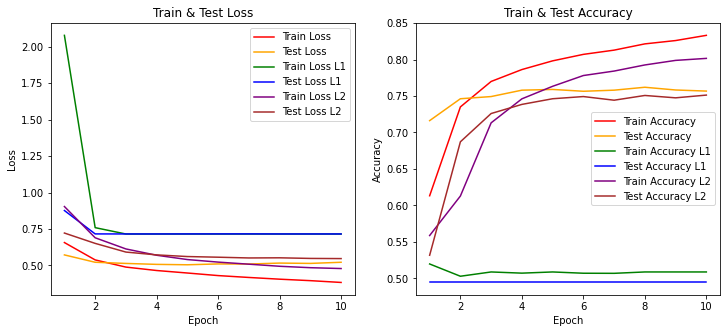

In [26]:
colors = ['red', 'orange', 'green', 'blue', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']
def create_lstm_model_final():
    model = Sequential()
    model.add(layers.Embedding(max_words, embedding_dim))
    for i in range(LSTM_layers):
        return_sequences = i < LSTM_layers - 1  
        model.add(layers.LSTM(LSTM_units, dropout=0.7, recurrent_dropout=0.1, return_sequences=return_sequences))
    model.add(layers.Dense(hidden_units, activation=hidden_act))
    model.add(layers.Dense(hidden_units, activation=hidden_act))
    model.add(layers.Dense(1, activation=output_act))

    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model
def create_lstm_model_l1():
    model = Sequential()
    model.add(layers.Embedding(max_words, embedding_dim))
    for i in range(LSTM_layers):
        return_sequences = i < LSTM_layers - 1 
        model.add(layers.LSTM(LSTM_units, dropout=0.7, recurrent_dropout=0.1, kernel_regularizer=regularizers.l1(0.01), return_sequences=return_sequences))
    model.add(layers.Dense(hidden_units, activation=hidden_act, kernel_regularizer=regularizers.l1(0.01)))
    model.add(layers.Dense(hidden_units, activation=hidden_act, kernel_regularizer=regularizers.l1(0.01)))
    model.add(layers.Dense(1, activation=output_act))

    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model
def create_lstm_model_l2():
    model = Sequential()
    model.add(layers.Embedding(max_words, embedding_dim))
    for i in range(LSTM_layers):
        return_sequences = i < LSTM_layers - 1  
        model.add(layers.LSTM(LSTM_units, dropout=0.7, recurrent_dropout=0.1, kernel_regularizer=regularizers.l2(0.01), return_sequences=return_sequences))
    model.add(layers.Dense(hidden_units, activation=hidden_act, kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dense(hidden_units, activation=hidden_act, kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dense(1, activation=output_act))

    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_lstm_model_final()
model2 = create_lstm_model_l1()
model3 = create_lstm_model_l2()
history = model.fit(
    train_data, train_label,
    epochs=num_epochs,
    batch_size=mini_batch,
    validation_data=(test_data, test_label),
    verbose=2
    )
history2 = model2.fit(
    train_data, train_label,
    epochs=num_epochs,
    batch_size=mini_batch,
    validation_data=(test_data, test_label),
    verbose=2
    )
history3 = model3.fit(
    train_data, train_label,
    epochs=num_epochs,
    batch_size=mini_batch,
    validation_data=(test_data, test_label),
    verbose=2
    )
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='Train Loss', color=colors[0])
axes[0].plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Test Loss', color=colors[1])
axes[0].plot(range(1, len(history2.history['loss']) + 1), history2.history['loss'], label='Train Loss L1', color=colors[2])
axes[0].plot(range(1, len(history2.history['val_loss']) + 1), history2.history['val_loss'], label='Test Loss L1', color=colors[3])
axes[0].plot(range(1, len(history3.history['loss']) + 1), history3.history['loss'], label='Train Loss L2', color=colors[4])
axes[0].plot(range(1, len(history3.history['val_loss']) + 1), history3.history['val_loss'], label='Test Loss L2', color=colors[5])
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Train & Test Loss")
axes[0].legend()

axes[1].plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], label='Train Accuracy', color=colors[0])
axes[1].plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], label='Test Accuracy', color=colors[1])
axes[1].plot(range(1, len(history2.history['accuracy']) + 1), history2.history['accuracy'], label='Train Accuracy L1', color=colors[2])
axes[1].plot(range(1, len(history2.history['val_accuracy']) + 1), history2.history['val_accuracy'], label='Test Accuracy L1', color=colors[3])
axes[1].plot(range(1, len(history3.history['accuracy']) + 1), history3.history['accuracy'], label='Train Accuracy L2', color=colors[4])
axes[1].plot(range(1, len(history3.history['val_accuracy']) + 1), history3.history['val_accuracy'], label='Test Accuracy L2', color=colors[5])
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Train & Test Accuracy")
axes[1].legend()

Epoch 1/10
250/250 - 22s - 89ms/step - accuracy: 0.6478 - loss: 0.6216 - val_accuracy: 0.7325 - val_loss: 0.5498
Epoch 2/10
250/250 - 19s - 75ms/step - accuracy: 0.7469 - loss: 0.5186 - val_accuracy: 0.7490 - val_loss: 0.5185
Epoch 3/10
250/250 - 21s - 84ms/step - accuracy: 0.7726 - loss: 0.4834 - val_accuracy: 0.7533 - val_loss: 0.5136
Epoch 4/10
250/250 - 21s - 83ms/step - accuracy: 0.7856 - loss: 0.4607 - val_accuracy: 0.7550 - val_loss: 0.5067
Epoch 5/10
250/250 - 21s - 82ms/step - accuracy: 0.7974 - loss: 0.4430 - val_accuracy: 0.7533 - val_loss: 0.5073
Epoch 6/10
250/250 - 20s - 82ms/step - accuracy: 0.8093 - loss: 0.4241 - val_accuracy: 0.7570 - val_loss: 0.5104
Epoch 7/10
250/250 - 20s - 78ms/step - accuracy: 0.8167 - loss: 0.4121 - val_accuracy: 0.7575 - val_loss: 0.5174
Epoch 8/10
250/250 - 21s - 83ms/step - accuracy: 0.8211 - loss: 0.3991 - val_accuracy: 0.7575 - val_loss: 0.5135
Epoch 9/10
250/250 - 19s - 78ms/step - accuracy: 0.8279 - loss: 0.3887 - val_accuracy: 0.7560 - 

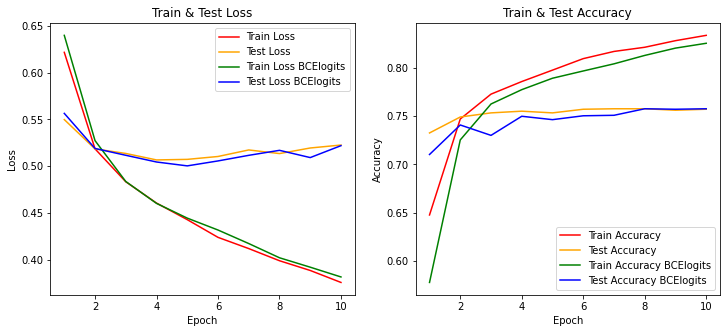

In [27]:
def create_lstm_model_BCElogits():
    model = Sequential()
    model.add(layers.Embedding(max_words, embedding_dim))
    for i in range(LSTM_layers):
        return_sequences = i < LSTM_layers - 1 
        model.add(layers.LSTM(LSTM_units, dropout=0.7, recurrent_dropout=0.1, return_sequences=return_sequences))
    model.add(layers.Dense(hidden_units, activation=hidden_act))
    model.add(layers.Dense(hidden_units, activation=hidden_act))
    model.add(layers.Dense(1))
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss=loss, metrics=['accuracy'])
    return model
model = create_lstm_model_final()
model2 = create_lstm_model_BCElogits()
history = model.fit(
    train_data, train_label,
    epochs=num_epochs,
    batch_size=mini_batch,
    validation_data=(test_data, test_label),
    verbose=2
    )
history2 = model2.fit(
    train_data, train_label,
    epochs=num_epochs,
    batch_size=mini_batch,
    validation_data=(test_data, test_label),
    verbose=2
    )

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='Train Loss', color=colors[0])
axes[0].plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Test Loss', color=colors[1])
axes[0].plot(range(1, len(history2.history['loss']) + 1), history2.history['loss'], label='Train Loss BCElogits', color=colors[2])
axes[0].plot(range(1, len(history2.history['val_loss']) + 1), history2.history['val_loss'], label='Test Loss BCElogits', color=colors[3])
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Train & Test Loss")
axes[0].legend()

axes[1].plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], label='Train Accuracy', color=colors[0])
axes[1].plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], label='Test Accuracy', color=colors[1])
axes[1].plot(range(1, len(history2.history['accuracy']) + 1), history2.history['accuracy'], label='Train Accuracy BCElogits', color=colors[2])
axes[1].plot(range(1, len(history2.history['val_accuracy']) + 1), history2.history['val_accuracy'], label='Test Accuracy BCElogits', color=colors[3])
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Train & Test Accuracy")
axes[1].legend()

Epoch 1/10
250/250 - 24s - 95ms/step - accuracy: 0.6471 - loss: 0.6243 - val_accuracy: 0.7107 - val_loss: 0.5559
Epoch 2/10
250/250 - 20s - 80ms/step - accuracy: 0.7423 - loss: 0.5245 - val_accuracy: 0.7517 - val_loss: 0.5150
Epoch 3/10
250/250 - 21s - 85ms/step - accuracy: 0.7731 - loss: 0.4852 - val_accuracy: 0.7515 - val_loss: 0.5112
Epoch 4/10
250/250 - 41s - 164ms/step - accuracy: 0.7891 - loss: 0.4584 - val_accuracy: 0.7563 - val_loss: 0.5069
Epoch 5/10
250/250 - 21s - 86ms/step - accuracy: 0.7961 - loss: 0.4427 - val_accuracy: 0.7592 - val_loss: 0.5092
Epoch 6/10
250/250 - 22s - 87ms/step - accuracy: 0.8080 - loss: 0.4250 - val_accuracy: 0.7600 - val_loss: 0.5095
Epoch 7/10
250/250 - 21s - 83ms/step - accuracy: 0.8137 - loss: 0.4142 - val_accuracy: 0.7615 - val_loss: 0.5022
Epoch 8/10
250/250 - 28s - 111ms/step - accuracy: 0.8207 - loss: 0.4000 - val_accuracy: 0.7588 - val_loss: 0.5050
Epoch 9/10
250/250 - 28s - 111ms/step - accuracy: 0.8265 - loss: 0.3899 - val_accuracy: 0.7573

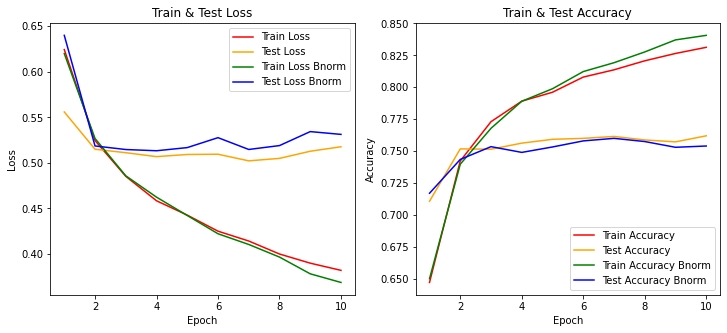

In [28]:
def create_lstm_model_bnorm():
    model = Sequential()
    model.add(layers.Embedding(max_words, embedding_dim))
    for i in range(LSTM_layers):
        return_sequences = i < LSTM_layers - 1 
        model.add(layers.LSTM(LSTM_units, dropout=0.7, recurrent_dropout=0.1, return_sequences=return_sequences))
        model.add(BatchNormalization())
    model.add(layers.Dense(hidden_units, activation=hidden_act))
    model.add(layers.Dense(hidden_units, activation=hidden_act))
    model.add(layers.Dense(1, activation=output_act))

    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model
model = create_lstm_model_final()
model2 = create_lstm_model_bnorm()
history = model.fit(
    train_data, train_label,
    epochs=num_epochs,
    batch_size=mini_batch,
    validation_data=(test_data, test_label),
    verbose=2
    )
history2 = model2.fit(
    train_data, train_label,
    epochs=num_epochs,
    batch_size=mini_batch,
    validation_data=(test_data, test_label),
    verbose=2
    )

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='Train Loss', color=colors[0])
axes[0].plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Test Loss', color=colors[1])
axes[0].plot(range(1, len(history2.history['loss']) + 1), history2.history['loss'], label='Train Loss Bnorm', color=colors[2])
axes[0].plot(range(1, len(history2.history['val_loss']) + 1), history2.history['val_loss'], label='Test Loss Bnorm', color=colors[3])
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Train & Test Loss")
axes[0].legend()

axes[1].plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], label='Train Accuracy', color=colors[0])
axes[1].plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], label='Test Accuracy', color=colors[1])
axes[1].plot(range(1, len(history2.history['accuracy']) + 1), history2.history['accuracy'], label='Train Accuracy Bnorm', color=colors[2])
axes[1].plot(range(1, len(history2.history['val_accuracy']) + 1), history2.history['val_accuracy'], label='Test Accuracy Bnorm', color=colors[3])
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Train & Test Accuracy")
axes[1].legend()

Epoch 1/10
250/250 - 23s - 92ms/step - accuracy: 0.6524 - loss: 0.6223 - val_accuracy: 0.7220 - val_loss: 0.5485
Epoch 2/10
250/250 - 20s - 78ms/step - accuracy: 0.7454 - loss: 0.5184 - val_accuracy: 0.7458 - val_loss: 0.5152
Epoch 3/10
250/250 - 20s - 80ms/step - accuracy: 0.7716 - loss: 0.4813 - val_accuracy: 0.7498 - val_loss: 0.5052
Epoch 4/10
250/250 - 21s - 83ms/step - accuracy: 0.7871 - loss: 0.4555 - val_accuracy: 0.7483 - val_loss: 0.5085
Epoch 5/10
250/250 - 19s - 77ms/step - accuracy: 0.8004 - loss: 0.4393 - val_accuracy: 0.7540 - val_loss: 0.5089
Epoch 6/10
250/250 - 19s - 77ms/step - accuracy: 0.8117 - loss: 0.4226 - val_accuracy: 0.7555 - val_loss: 0.5104
Epoch 7/10
250/250 - 19s - 78ms/step - accuracy: 0.8183 - loss: 0.4077 - val_accuracy: 0.7595 - val_loss: 0.5111
Epoch 8/10
250/250 - 19s - 77ms/step - accuracy: 0.8269 - loss: 0.3935 - val_accuracy: 0.7575 - val_loss: 0.5175
Epoch 9/10
250/250 - 19s - 77ms/step - accuracy: 0.8315 - loss: 0.3847 - val_accuracy: 0.7540 - 

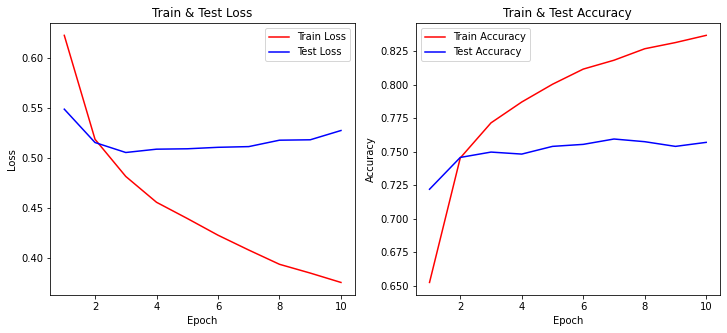

In [30]:
def create_lstm_model_final():
    model = Sequential()
    model.add(layers.Embedding(max_words, embedding_dim))
    for i in range(LSTM_layers):
        return_sequences = i < LSTM_layers - 1 
        model.add(layers.LSTM(LSTM_units, dropout=0.7, recurrent_dropout=0.1, return_sequences=return_sequences))
    model.add(layers.Dense(hidden_units, activation=hidden_act))
    model.add(layers.Dense(hidden_units, activation=hidden_act))
    model.add(layers.Dense(1, activation=output_act))

    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model
model = create_lstm_model_final()

history = model.fit(
    train_data, train_label,
    epochs=num_epochs,
    batch_size=mini_batch,
    validation_data=(test_data, test_label),
    verbose=2
    )

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='Train Loss', color=colors[0])
axes[0].plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Test Loss', color=colors[3])
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Train & Test Loss")
axes[0].legend()

axes[1].plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], label='Train Accuracy', color=colors[0])
axes[1].plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], label='Test Accuracy', color=colors[3])
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Train & Test Accuracy")
axes[1].legend()